## Bootstrap

This notebook introduces the suggested use of bootstrap to estimate the variance due to pathway and parameter uncertainty.

**Note** this page is computationally intensive.

We use the same locations as the basic pathways example, specified in the block below.

In [1]:
import driftmlp
import numpy as np
import matplotlib.pyplot as plt
import os
from cartopy import crs as ccrs

#Set seed for reproducibility
np.random.seed(1)

#Copy sample locations from basic_pathways page
from_loc = [-90.90, 23.88]
to_loc =[-9.88, 35.80] 
locs = {
    "Gulf of Mexico": from_loc,
    "Strait of Gibraltar": to_loc,
    "North Atlantic" : [-41, 34],
    "South Atlantic" : [-14, -27], 
    "North Pacific" : [-170, 30]
}
N_locs = len(locs)

### Make the network.

For the bootstrap we require more direct access to the drifter data. The network loaded by `driftmlp.read_default_network` does not contain enough information about the original data to carry out bootstrapping. We need the original sequence of discrete indices.

Therefore, we recreate the network below. The store_story stores a list of the discrete indices of the data. This is sufficient for bootstrapping.

In [2]:
DFILE = os.environ['DRIFTFILE']
%time T_mat = driftmlp.driftfile_to_network(DFILE, store_story=True)
%time T_mat_bootstrap = driftmlp.BootstrapNetwork(T_mat)

CPU times: user 5min 33s, sys: 4.69 s, total: 5min 38s
Wall time: 5min 50s
CPU times: user 31.8 s, sys: 119 ms, total: 31.9 s
Wall time: 31.9 s


Most of the computational time used is spent on discretizing the longitude, latitude pairs. Once these are read into memory the process is relatively quick. Luckily for the bootstrap we only need to discretize once.

What if we do not want the original transition matrix? We can save a bit of time by getting the stories. However this is a very minor speed up.

In [3]:
##Create the drifter generator then call it.
from driftmlp.drifter_indexing import driftiter, story
import numpy as np 
drift_gen = driftiter.generator(DFILE)()
print("Time to load into memory and discretize:")
%time drift_story = story.get_story(drift_gen)
boot_ids = np.random.randint(low=0, high=len(drift_story), size=len(drift_story), dtype=int).tolist()
boot_stories = [drift_story[i] for i in boot_ids]

print("Time to create network from the bootstrapped sample:")
%time boot_network2 = driftmlp.form_network.make_transition(boot_stories)
del boot_stories, boot_ids

Time to load into memory and discretize:
CPU times: user 5min 6s, sys: 4.16 s, total: 5min 10s
Wall time: 5min 21s
Time to create network from the bootstrapped sample:
CPU times: user 32.3 s, sys: 203 ms, total: 32.5 s
Wall time: 32.5 s


### Typical application of bootstrap

We will simulate 10 bootstrap samples then do some basic exploratory results to get an idea of how variable the travel times are for the `locs` array.

Here we remove the Panama and Strait of Gibraltar connections by calling the function `remove_undesired`. See the Rotations section for an example of what happens if this is not done.

In [4]:
N_BOOT = 10
# Generate networks, this is computationally hard bit and it involves randomness.
print(f"Time to estimate {N_BOOT} networks:")
%time boot_networks = [driftmlp.BootstrapNetwork(T_mat) for _ in range(N_BOOT)]

# Removes the Panama and Strait of Gibraltar artificial connections
for i in range(N_BOOT):
    driftmlp.helpers.remove_undesired(T_mat)
    
# Discretize the locations
h3_ids = driftmlp.DefaultSystem.return_inds(locs.values())
# Get all pathways
pairwise_boot_paths = [driftmlp.shortest_path.AllPairwisePaths(boot_T, h3_ids) for boot_T in boot_networks]

Time to estimate 10 networks:
CPU times: user 5min 38s, sys: 1.62 s, total: 5min 40s
Wall time: 5min 40s


Below we'll look at the overall variance in the pathway. A darker line implies more uncertainty in the pathway

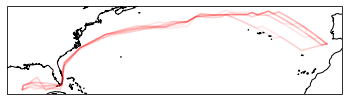

In [5]:
from driftmlp.plotting import h3_cartopy
gpd_df = driftmlp.plotting.make_gpd.full_multipolygon_df()
from_idx = 0
to_idx = 1
fig = plt.figure()
ax = plt.subplot(projection = ccrs.PlateCarree())

for i in range(N_BOOT):
    # Plot bootstrapped lines to show uncertainty in pathways.
    pathway = pairwise_boot_paths[i][from_idx][to_idx]
    h3_cartopy.plot_line(gpd_df, pathway.h3id, ax=ax, alpha=0.1, color='red', centroid_col='centroid_col')
ax.coastlines()

In [6]:
def extract_travel_time_matrix(list_of_lists):
    """
    Turn a list of lists of network paths into an array
    
    Prints a warning if there is an invalid path
    """
    tt = np.array([[path.travel_time for path in list_of_paths] for list_of_paths in list_of_lists])
    if np.any(tt<0):
        print("WARNING: There's an invalid path")
    return tt

travel_time_array = np.stack([extract_travel_time_matrix(bootstrap_paths) for bootstrap_paths in pairwise_boot_paths])

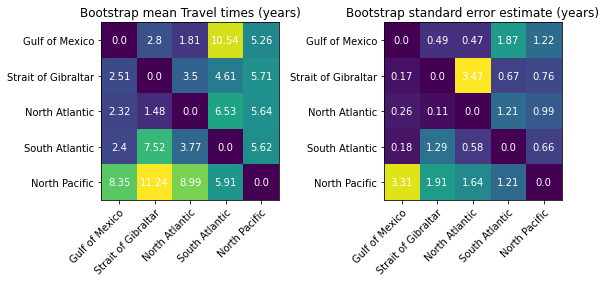

In [7]:
def make_heatmap(arr, ax):
    ax.set_xticks(np.arange(N_locs))
    ax.set_yticks(np.arange(N_locs))
    # ... and label them with the respective list entries
    ax.set_xticklabels(locs.keys())
    ax.set_yticklabels(locs.keys())
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(N_locs):
        for j in range(N_locs):
            text = ax.text(j, i, np.round(arr[i, j]/365,2) ,
                           ha="center", va="center", color="w")

    

    ax.imshow(arr)
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].set_title("Bootstrap mean Travel times (years)")
make_heatmap(travel_time_array.mean(axis=0), ax = ax[0])
ax[1].set_title("Bootstrap standard error estimate (years)")
make_heatmap(travel_time_array.std(axis=0, ddof=1), ax=ax[1])
fig.tight_layout()

The heatmap shows that generally lower travel times come with lower uncertainty as we would expect. We could also compare the bootstrap mean to what we could get from the vanilla method:

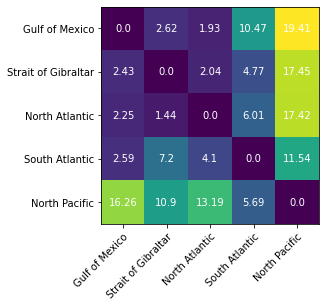

In [8]:
tt_classic = extract_travel_time_matrix(driftmlp.shortest_path.AllPairwisePaths(T_mat, h3_ids))
fig, ax = plt.subplots()
make_heatmap(tt_classic, ax)

The results above are likely subject to a high level of noise. Typically number of boostrap samples are much higher however this would take considerably longer to run. In practice setting N_Boot higher (say to N_BOOT=100) is advised!

In practice we also find that the bootstrap mean is a more robust method to use than the classic method. It averages over many different potential pathways; hence giving a less noisey estimate of the travel time. 

For a similar example estimating a different source of error look at the rotation example section of the documentation.